In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

c:\Users\simeo\VSCodeProjects\StableAudioProject\ChordStuff\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 1.21G/1.21G [00:39<00:00, 33.0MB/s]

Extracting files...


Path to dataset files: C:\Users\simeo\.cache\kagglehub\datasets\andradaolteanu\gtzan-dataset-music-genre-classification\versions\1


In [17]:
import os
import glob
import torchaudio

dataset_path = r"C:\Users\simeo\.cache\kagglehub\datasets\andradaolteanu\gtzan-dataset-music-genre-classification\versions\1\Data\genres_original"

file_list = glob.glob(os.path.join(dataset_path, "*", "*.wav"))

print(f"Found {len(file_list)} audio files")

# Load a sample
waveform, sample_rate = torchaudio.load(file_list[0])
label = os.path.basename(os.path.dirname(file_list[0]))
print(waveform.shape, sample_rate, label)



Found 1000 audio files
torch.Size([1, 661794]) 22050 blues


c:\Users\simeo\VSCodeProjects\StableAudioProject\ChordStuff\.venv\lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


In [18]:
import torch
import torchaudio.transforms as T

spectrogram_transform = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=2048,
    hop_length=512,
    n_mels=128
)

spec = spectrogram_transform(waveform)  # Differentiable tensor
spec_db = T.AmplitudeToDB()(spec)

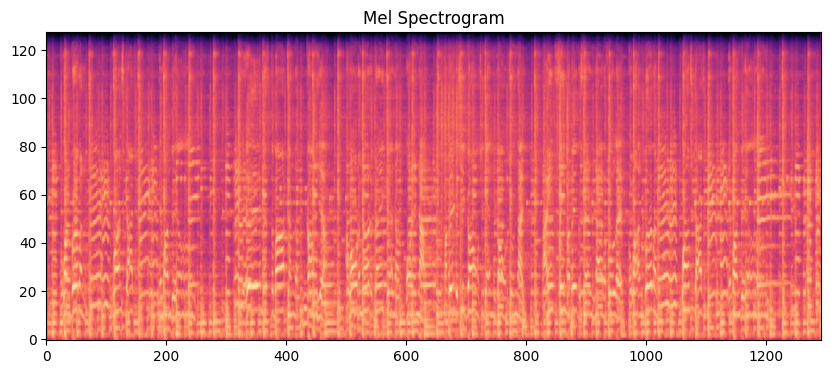

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.imshow(spec_db[0].detach().numpy(), origin='lower', aspect='auto', cmap='magma')
plt.title("Mel Spectrogram")
plt.show()


In [20]:
# Linear Projection

import torch
import torch.nn as nn

class DifferentiableChroma(nn.Module):
    def __init__(self, n_mels=128, n_chroma=12):
        super().__init__()
        # Projection: maps n_mels → 12 chroma bins
        self.projection = nn.Linear(n_mels, n_chroma, bias=False)
        
        # Optional: initialize with equal weights for roughly uniform distribution
        with torch.no_grad():
            self.projection.weight.fill_(1.0 / n_mels)
    
    def forward(self, mel_spec):
        """
        mel_spec: [B, n_mels, T]
        returns: [B, n_chroma, T]
        """
        # transpose to [B, T, n_mels] for linear layer
        x = mel_spec.transpose(1, 2)
        chroma = torch.relu(self.projection(x))
        # transpose back to [B, n_chroma, T]
        return chroma.transpose(1, 2)


Chroma shape: torch.Size([1, 12, 1293])


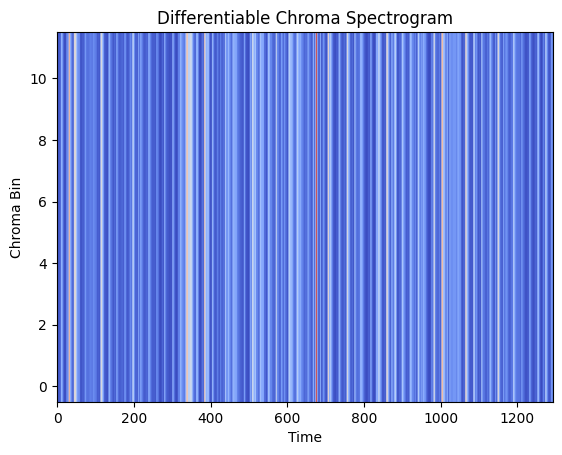

In [21]:
# Assume waveform and sample_rate already loaded
mel_spec = spectrogram_transform(waveform)  # [1, n_mels, T]
chroma_layer = DifferentiableChroma(n_mels=128)
chroma_spec = chroma_layer(mel_spec)    # [1, 12, T]

print("Chroma shape:", chroma_spec.shape)  # Should be [1, 12, T]

# Optional visualization
import matplotlib.pyplot as plt
plt.imshow(chroma_spec[0].detach().numpy(), origin='lower', aspect='auto', cmap='coolwarm')
plt.title("Differentiable Chroma Spectrogram")
plt.xlabel("Time")
plt.ylabel("Chroma Bin")
plt.show()


In [ ]:
# Write a callback function. when given denoised latent of audio, run decoder on the latent to get the actual audio, get actual audio, and then create chroma

In [22]:
# CQT-based Differentiable Chroma

import torch
import torch.nn as nn
import torchaudio.transforms as T

class DifferentiableChromaCQT(nn.Module):
    def __init__(self, sample_rate=22050, n_bins=84, bins_per_octave=12):
        """
        n_bins: total number of CQT bins (e.g., 7 octaves * 12 bins = 84)
        bins_per_octave: usually 12
        """
        super().__init__()
        self.cqt = T.CQT(
            sample_rate=sample_rate,
            n_bins=n_bins,
            bins_per_octave=bins_per_octave,
            hop_length=512,
            fmin=32.70,  # C1
            window='hann'
        )
        self.n_chroma = bins_per_octave
    
    def forward(self, waveform):
        """
        waveform: [B, 1, T] or [B, T]
        returns: chroma spectrogram [B, 12, frames]
        """
        if waveform.ndim == 2:
            waveform = waveform.unsqueeze(1)  # [B, 1, T]

        cqt_spec = self.cqt(waveform)  # [B, n_bins, frames]
        cqt_spec = torch.abs(cqt_spec)  # magnitude
        
        # Sum across octaves for chroma bins
        n_octaves = cqt_spec.shape[1] // self.n_chroma
        chroma_spec = cqt_spec.view(cqt_spec.shape[0], n_octaves, self.n_chroma, -1).sum(dim=1)
        # Now chroma_spec: [B, 12, frames]
        
        return chroma_spec


In [23]:
# waveform, sample_rate, label = dataset[0]  # or manual loader
waveform = waveform.unsqueeze(0)  # batch dimension

chroma_layer = DifferentiableChromaCQT(sample_rate=sample_rate)
chroma_spec = chroma_layer(waveform)

print("Chroma shape:", chroma_spec.shape)  # [B, 12, frames]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.imshow(chroma_spec[0].detach().numpy(), origin='lower', aspect='auto', cmap='coolwarm')
plt.title("Differentiable CQT Chroma Spectrogram")
plt.xlabel("Time")
plt.ylabel("Chroma Bin")
plt.show()


AttributeError: module 'torchaudio.transforms' has no attribute 'CQT'